In [1]:
!pip install matplotlib seaborn pandas numpy

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import json
import os
sns.set()

In [3]:
def get_backtest_path(file_name=""):
    backtest_results_path = "../backtest_results/"
    if file_name == "":
        last_result_path = backtest_results_path + ".last_result.json"
        last_result_file = json.load(open(last_result_path))
        optimization_path = backtest_results_path + last_result_file['latest_backtest']
    else:
        optimization_path = hyperopt_results_path + file_name
   
    return optimization_path

In [17]:
backtest = json.load(open(get_backtest_path()))

In [18]:
trades = pd.DataFrame(backtest['strategy']['StochRSI']['trades'])

<AxesSubplot: xlabel='profit_ratio', ylabel='Density'>

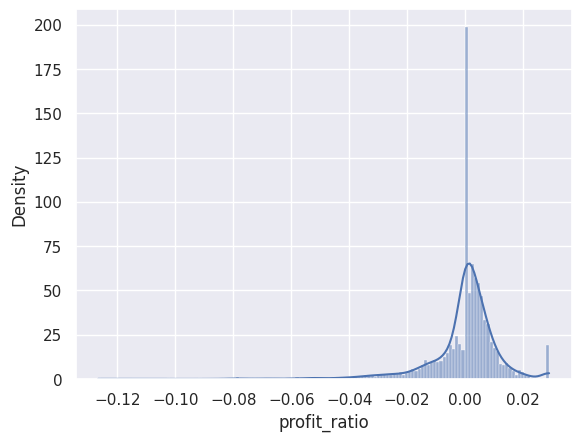

In [23]:
sns.histplot(trades['profit_ratio'], kde=True, stat="density")

<AxesSubplot: xlabel='profit_ratio', ylabel='Probability'>

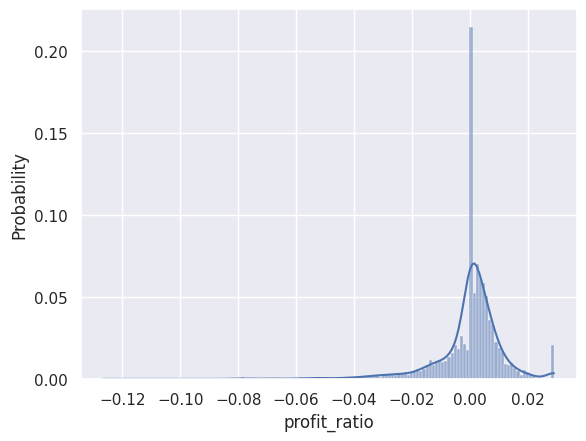

In [39]:
sns.histplot(trades['profit_ratio'] ,kde = True, stat='probability')

In [97]:
def load_data(file_name="", columns=[], refresh = False, trades = False):
    optimization_path = get_opt_path(file_name, not refresh, trades = trades)
    print('loading:', optimization_path)
    data = pd.DataFrame()
    trades = pd.DataFrame()
    if optimization_path.endswith('.csv') and not refresh:
        data = pd.read_csv(optimization_path)
    else:
        with open(optimization_path) as fp:
            while True:        
                line = fp.readline()        
                if not line:
                    break
                line_json = json.loads(line)
                param_columns = ["loss", *line_json["params_dict"]]
                line_trades = pd.DataFrame(line_json["results_metrics"]["trades"])
                values = [line_json["loss"], *list(line_json["params_dict"].values())]
                line_data = pd.DataFrame([values], columns = param_columns)
                data = pd.concat([data, line_data])
                trades = pd.concat([trades, line_trades])
    if len(columns) != 0:
        print('reordering columns: ')
        print(data.columns.tolist())
        print(columns)
        data = data[columns]
    if not optimization_path.endswith('.csv'):
        print('saving csv: ', optimization_path + '.csv')
        data.to_csv(optimization_path + '.csv')
    return data, trades

In [6]:
def hist_loss(data):
    loss = data['loss']
    sns.histplot(loss)
    mean = loss.mean()
    std = loss.std()
    plt.axvline(x=mean, ls='--', lw=1)
    plt.axvline(x=mean - std, ls='--', lw=.5)
    plt.axvline(x=mean + std, ls='--', lw=.5)
    plt.show()

In [7]:
def hist_params(data):
    params_number = len(data.columns) - 1 # exclude "loss" column
    columns_number = 3
    rows_number = int(params_number / columns_number) + 1
    axes_number = rows_number * columns_number
    
    row_height = 8
    fig_height = rows_number * row_height
    
    fig, axes = plt.subplots(rows_number , columns_number, figsize=(25, fig_height))
    
    for index in range(1, params_number + 1):
        key = data.columns[index]
        
        row_index = int((index - 1) / columns_number)
        column_index = (index - 1) % columns_number
        ax = axes[row_index, column_index]
        
        sns.histplot(data[key], ax = ax)
        
        if data[key].dtype.kind != 'O':
            mean = data[key].mean()
            std = data[key].std()
            ax.axvline(x=mean, ls='--', lw=1)
            ax.axvline(x=mean - std, ls='--', lw=.5)
            ax.axvline(x=mean + std, ls='--', lw=.5)
    
    for index in range(axes_number - 1, params_number - 1, -1):
        row_index = int(index / columns_number)
        column_index = index % columns_number
        axes[row_index, column_index].remove()
    
    plt.show()
        

In [8]:
def getCombinations(seq):
    combinations = list()
    for i in range(0,len(seq)):
        for j in range(i+1,len(seq)):
            combinations.append([seq[i],seq[j]])
    return combinations

In [9]:
def binify(data_i, bins = 10):
    data = data_i.copy()
    for index in range(1, len(data.columns)):
        key = data.columns[index]
        bins_list = []
        if data_i[key].dtype.kind == 'O':
            # bins_list = data_i[key].unique()
            data[key] = data_i[key]
        else:
            bins_list = np.linspace(data[key].min(), data[key].max(), bins)
            data[key] = bins_list[np.digitize(data[key], bins_list, True)]
    return data

In [10]:
from matplotlib.ticker import MultipleLocator, FuncFormatter

def plot_heatmaps(data, bins = 10):
    bined_data = binify(data, bins)
    index = pd.MultiIndex.from_frame(bined_data[data.columns[1:]])
    series = pd.Series(data['loss'].values, index = index)
    combinations = getCombinations(data.columns[1:])
    best_params = []
    
    columns_number = len(data.columns) - 1
    rows_number = columns_number
    
    fig, axes = plt.subplots(rows_number, columns_number, figsize=(25, 20))
    column = 0
    row = 1
    for combination in combinations:
        method = 'linear'
        limit_direction = 'backward'
        heatmap = series.groupby(combination).mean().unstack().transpose()
        
        if row == rows_number:
            column += 1
            row = column + 1
        ax = axes[row, column]
        
        sns.heatmap(heatmap, cmap='magma_r', ax = ax, cbar=False)
        ax.margins(0)
        if column != 0:
            ax.set_yticklabels([])
        if row + 1 != rows_number:
            ax.set_xticklabels([])
             
        ax.set_title("")
        ax.set_ylabel("")
        ax.set_xlabel("")
        
        row += 1
    
    # plot partial dependecies
    index = 0
    for column in data.columns:
        if column == 'loss':
            continue
        objective = series.groupby([column]).mean()
        rolling_mean = objective.rolling(int(objective.size / 2), center=True, min_periods=1).mean()
        ax = axes[index,index]
        ax.xaxis.set_ticks_position('top')
        ax.yaxis.set_ticks_position('right')
        ax.axvline(x=rolling_mean.idxmin(), ls='--', lw=1, color='orange')
        ax.plot(objective)
        ax.plot(rolling_mean)
        ax.set_title(column)
        ax.margins(0)
        
        best_params.append((column, rolling_mean.idxmin()))
        
        index += 1
        
    # remove not needed axes
    for i in range(columns_number):
        for j in range(columns_number):
            if i < j:
                axes[i, j].remove()
    fig.tight_layout()
    
    plt.show()
    
    print(best_params)

loading: ../hyperopt_results/strategy_StochRSI_2023-02-11_21-23-46.fthypt
reordering columns: 
['loss', 'enter_method', 'over_bought', 'over_sold', 'rsi_length', 'stoch_length', 'close_on_return', 'exit_method', 'take_profit', 'timeout']
['loss', 'over_bought', 'over_sold', 'rsi_length', 'stoch_length', 'take_profit', 'timeout', 'enter_method', 'exit_method', 'close_on_return']
saving csv:  ../hyperopt_results/strategy_StochRSI_2023-02-11_21-23-46.fthypt.csv
Mean loss: -45.972404878269224
Std loss: 81.0771902639768
Mean/Std loss: -0.5670202029521378


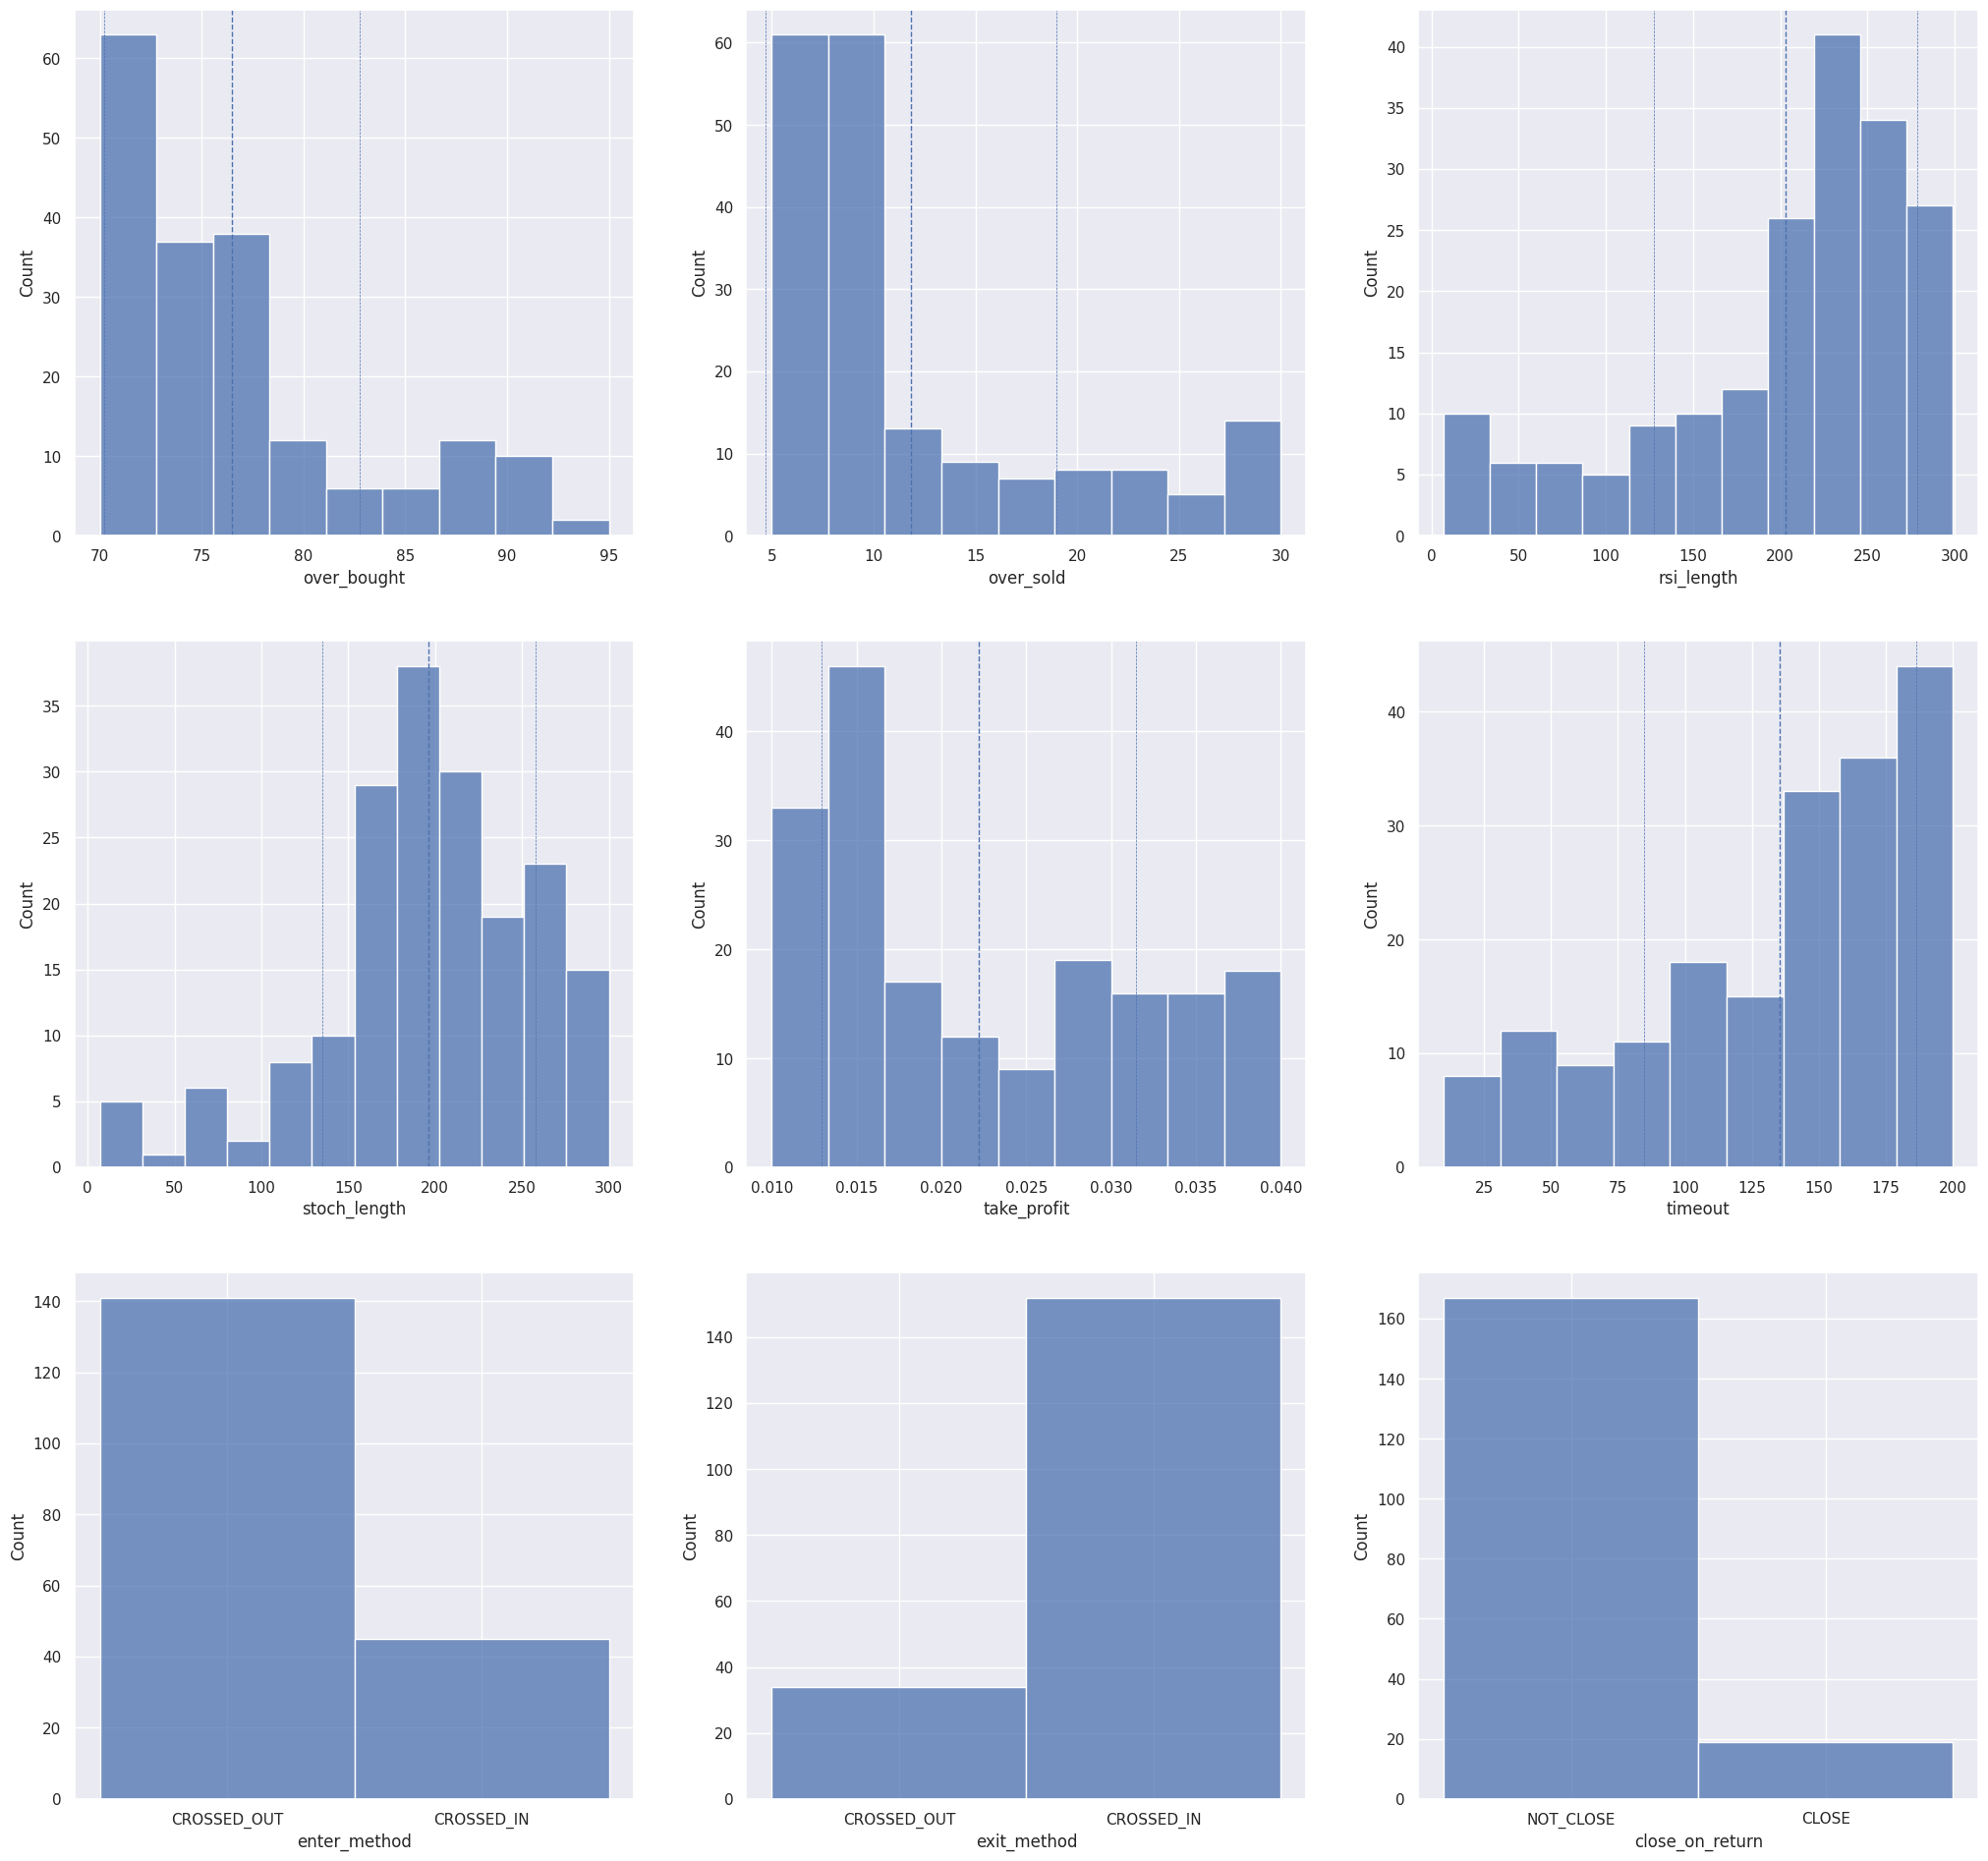

In [98]:
columns = ['loss','over_bought', 'over_sold', 'rsi_length', 'stoch_length', 'take_profit', 'timeout', 'enter_method', 'exit_method', 'close_on_return']
file_name = 'strategy_StochRSI_2023-02-11_21-23-46.fthypt'
data, trades = load_data(file_name, columns=columns, trades=True)
calc_loss(data)
hist_params(data)

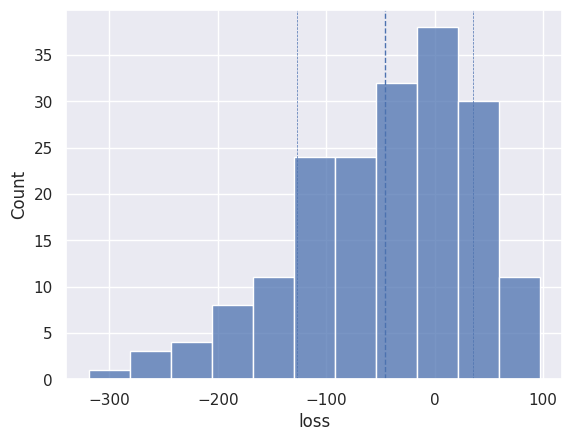

In [87]:
hist_loss(data)

0.00018177406979194514

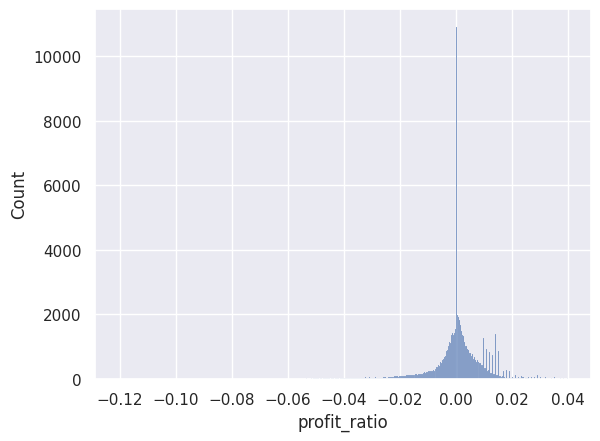

In [99]:
sns.histplot(trades['profit_ratio'])
trades['profit_ratio'].mean()

KeyboardInterrupt: 

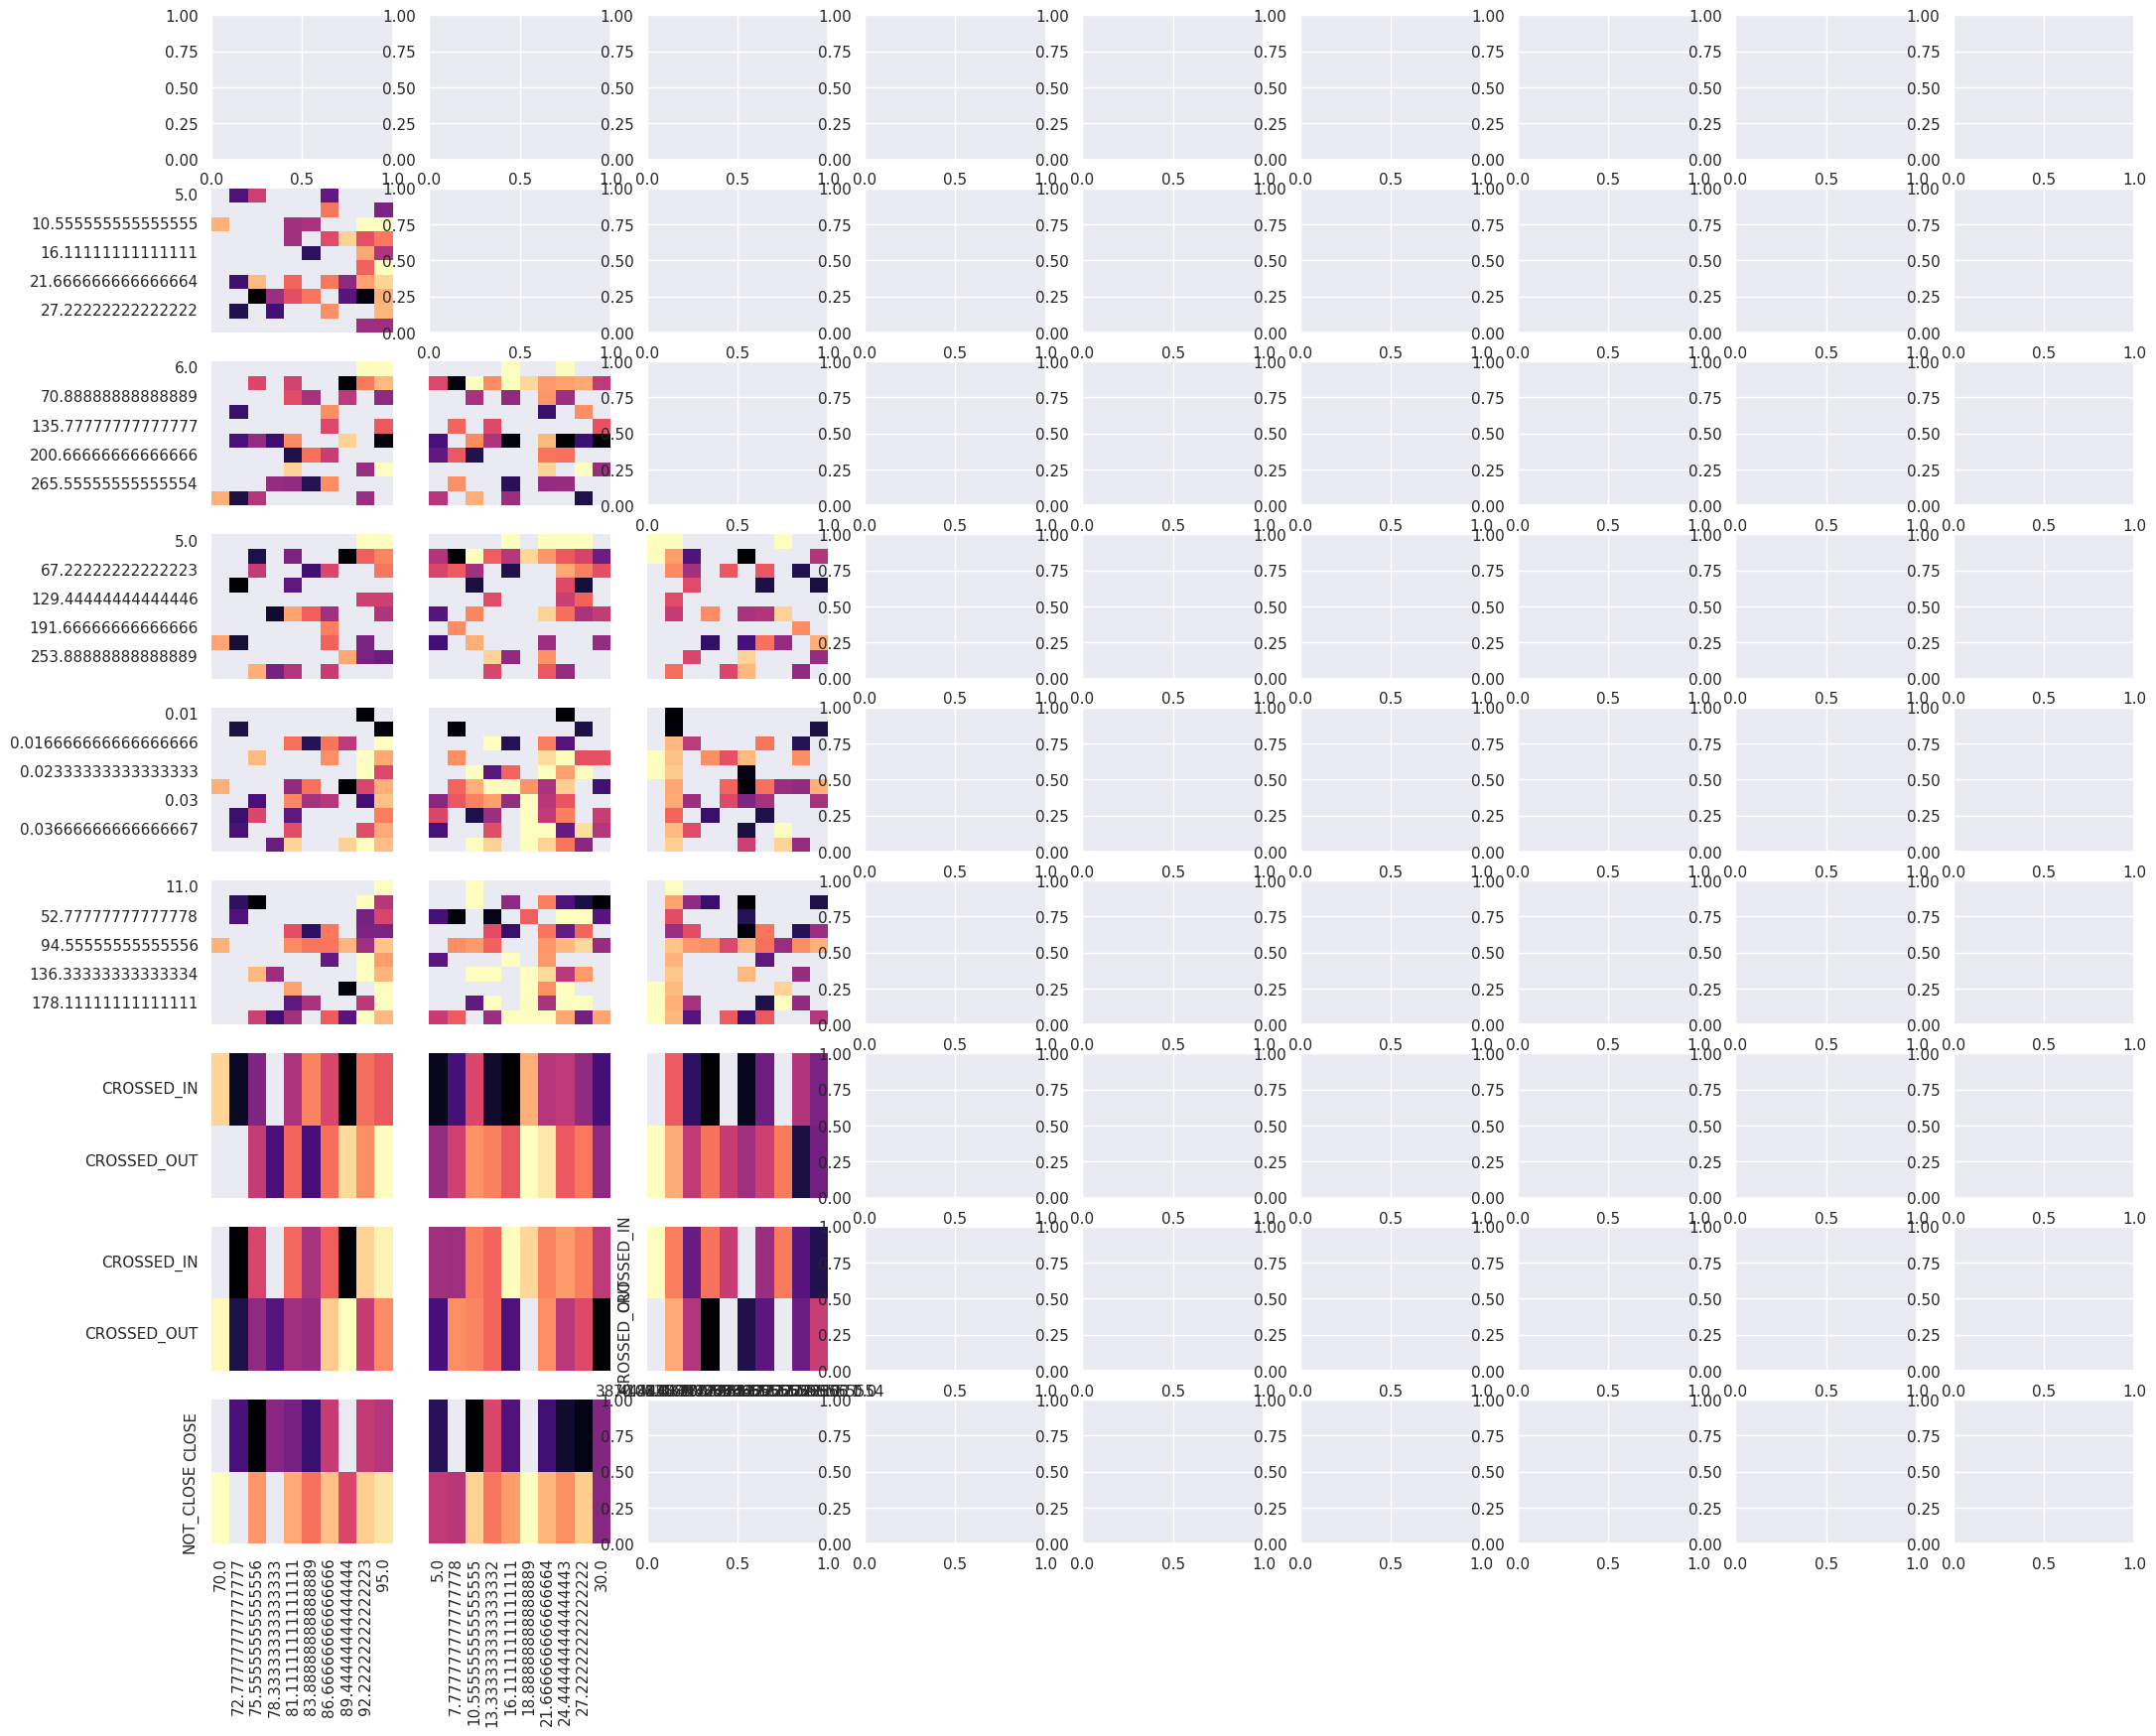

In [18]:
plot_heatmaps(data, 10)